## Fake Review Detector
#### Import necessary libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import acessory_func as af

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     C:\Users\andy\AppData\Roaming\nltk_data...
[nltk_data]    |   Pac

#### Step 1: Examine dataset

In [4]:
# Read the adatset an display the 5 rows randomly
df = pd.read_csv('../dataset/fake reviews dataset.csv')
df.sample(5)

,category,rating,label,text_
35953,Toys_and_Games_5,2.0,OR,Hi - I bought this sit and spin because I reme...
21346,Pet_Supplies_5,5.0,CG,I try different bird seeds and flavors and thi...
5229,Sports_and_Outdoors_5,3.0,OR,Item arrived and looks great will try this wee...
20566,Pet_Supplies_5,5.0,CG,Bought this for my Bosses and it was the best ...
8430,Electronics_5,4.0,CG,Works as well as I'd hoped. The only problem i...


In [5]:
# Basic Information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


The dataset have 40432 rows and 4 columns with no missing values.

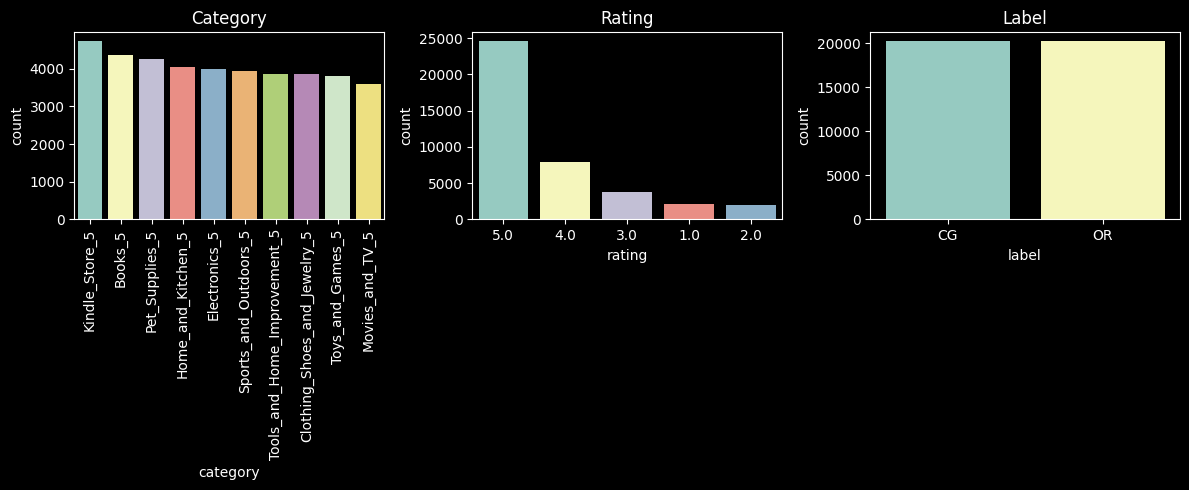

In [6]:
# Count plot for each column
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 5))
sns.countplot(x='category', data=df, ax=ax[0], order=df['category'].value_counts().index)
sns.countplot(x='rating', data=df, ax=ax[1], order=df['rating'].value_counts().index)
sns.countplot(x='label', data=df, ax=ax[2], order=df['label'].value_counts().index)

ax[0].set_title('Category')
ax[1].set_title('Rating')
ax[2].set_title('Label')

ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

From the above count plot:
- The number of reviews for each category ranges between 3500 to 4800.
- The number of rating '5' is more then the sum of the other four ratings (bias towards rating '5').
- The dataset is balanced.

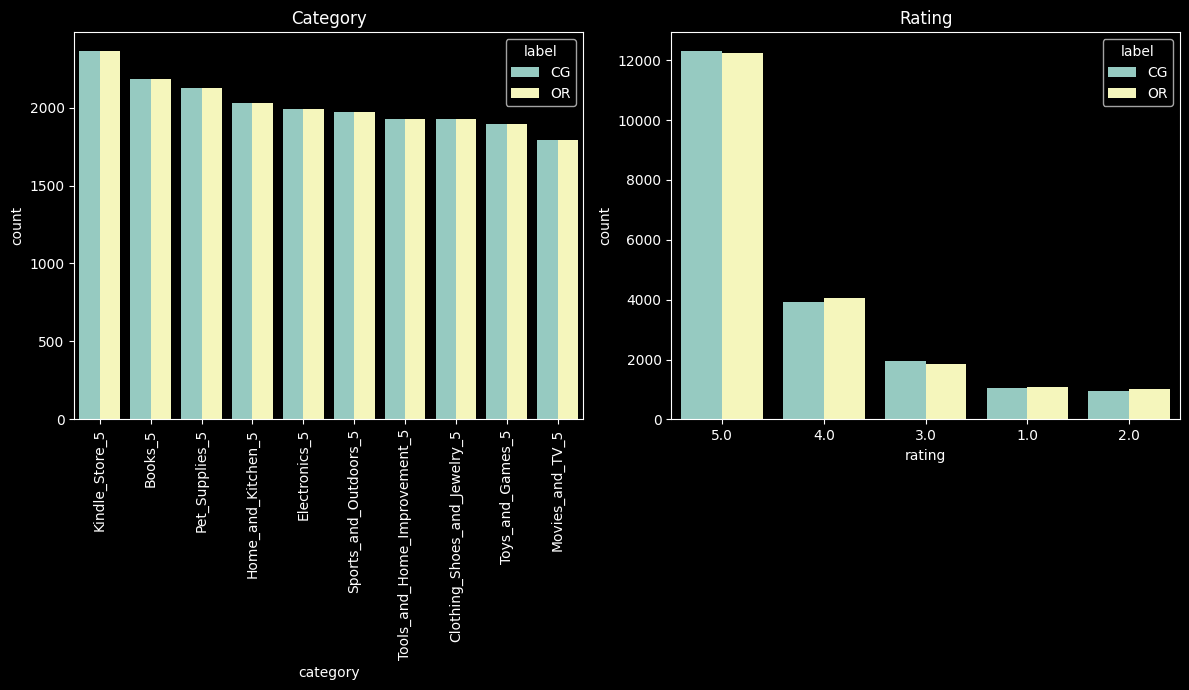

In [7]:
# Count plot for number of True (OR) or Fake (CG) reviews in each category and rating
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
sns.countplot(x='category', hue='label', data=df, ax=ax[0], order=df['category'].value_counts().index)
sns.countplot(x='rating', hue='label', data=df, ax=ax[1], order=df['rating'].value_counts().index)

ax[0].set_title('Category')
ax[1].set_title('Rating')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()

The True (OR) or Fake (CG) reviews in each category and rating are quite balanced.

#### Data Cleaning

In [8]:
# Check if reviews contain any URL
df[df['text_'].str.contains('http')]['text_'].sample(5, random_state=42)

23539    If you aren't able to open the door for your d...
3749     With growing pains always on the prowl, my dau...
3103     <div id="video-block-RCLJDSSDKWYNA" class="a-s...
36534    <div id="video-block-R13NRMAER1K3U8" class="a-...
23252    <div id="video-block-R37AHS6LQISNA1" class="a-...
Name: text_, dtype: object

In [9]:
# Call fuctions from acessory_func.py to remove URL
df['text_'] = af.remove_url(df['text_'])

df['text_'].str.contains('http').sum()

0

#### Exploratory Data Analysis
1.	Any difference between the reviews for both labels?

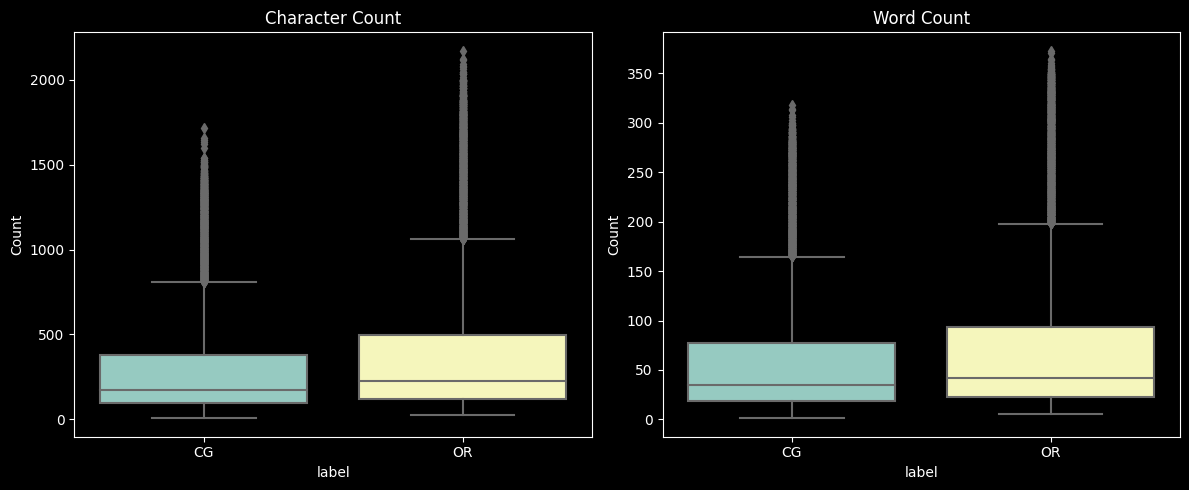

In [10]:
# Compare Character and Word count for True ('OR') and Fake ('CG') reviews
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
sns.boxplot(x='label', y=df['text_'].str.len(), data=df, ax=ax[0])
sns.boxplot(x='label', y=df['text_'].str.split().str.len(), data=df, ax=ax[1])

ax[0].set_title('Character Count')
ax[0].set_ylabel('Count')
ax[1].set_title('Word Count')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

There are more characters and words in true reviews compare to the fake reviews as shown in Figure 7. The median count of characters and words for both labels are quite close. For fake reviews, the middle 50% of character count ranges from between around 100 to 400 and ranges between around 150 to 500 for true reviews. As for word count, the middle 50% ranges from around 25 to 75 for fake reviews, around 30 to 100 for true reviews.

2.	What is the most common word used in both labels?

In [11]:
# Call function from acessory_func.py to convert all text to lower case and remove numbers, punctuations and stop words
# Keep apostrophe "'" to keep words that are contractions in the text
# Keep "not" and "didn't" in the text
df['new_text_'] = af.cleaning(df['text_'], stopwords_to_exclude=['not', "didn't"], punc_to_exclude="'")

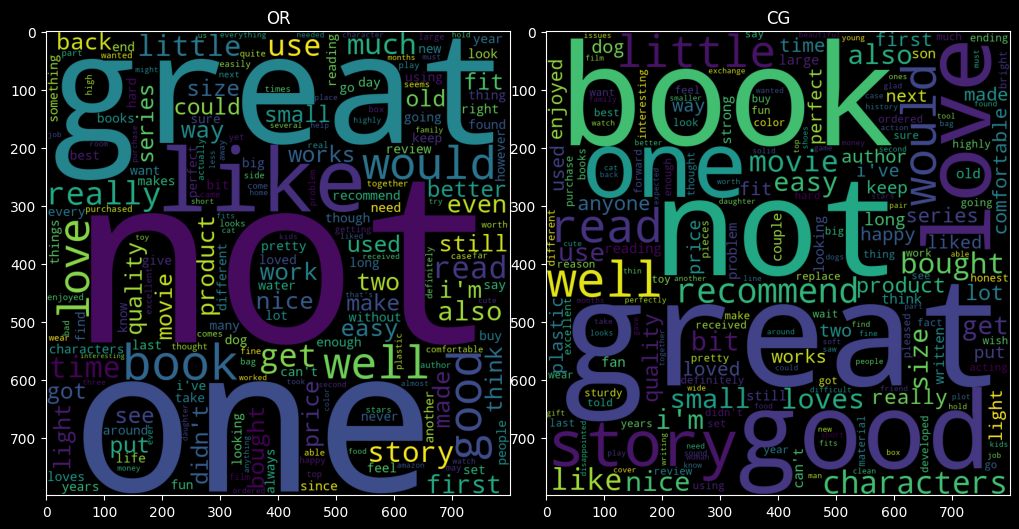

In [26]:
# Create word cloud for each label
real = df[df['label'] == 'OR'].new_text_
fake = df[df['label'] == 'CG'].new_text_

wordcloud = WordCloud(width=800, height=800, min_font_size=10)

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=2)
ax[0].imshow(wordcloud.generate_from_frequencies(real.str.split().explode().value_counts()))
ax[0].set_title('OR')
ax[1].imshow(wordcloud.generate_from_frequencies(fake.str.split().explode().value_counts()))
ax[1].set_title('CG')

plt.tight_layout(pad=0)
plt.show()

Most common words used in both labels look similar from the word cloud in Figure 8. We will use a bar chart instead to see the actual count of the top 20 words used in both label and see if there is any difference.

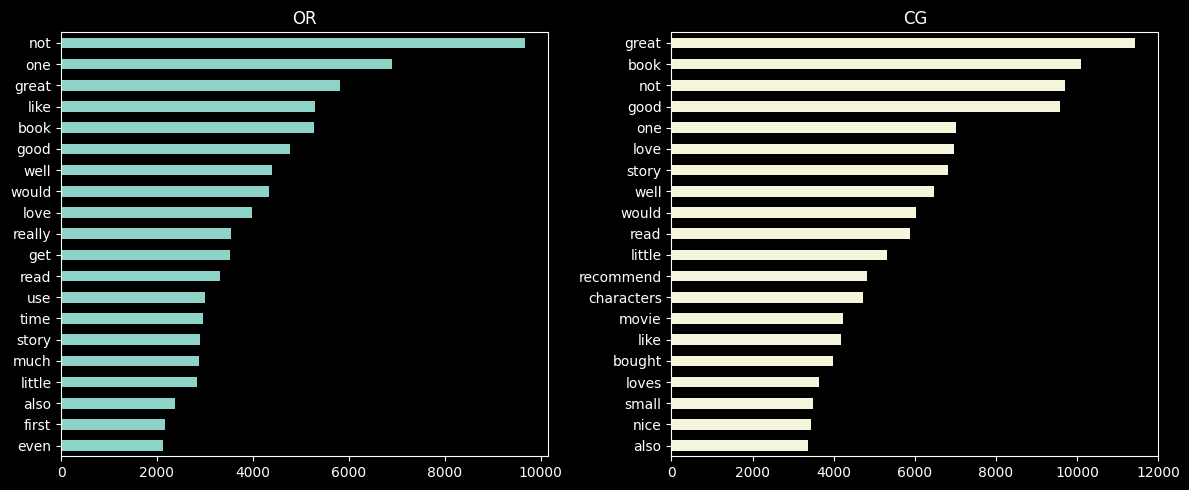

In [27]:
# Plot the top 20 words for each label
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
real.str.split().explode().value_counts().head(20).sort_values().plot.barh(x='Word', y='Count', ax=ax[0], legend=False)
fake.str.split().explode().value_counts().head(20).sort_values().plot.barh(x='Word', y='Count', ax=ax[1], legend=False, color='beige')

ax[0].set_title('OR')
ax[1].set_title('CG')

plt.tight_layout()
plt.show()

The top 20 words in both labels are mostly positive words like “great, good, love, well”. This is not surprised as more than half of the reviews in the dataset are in the ratings of 5.0. But the fake reviews (CG) use much more of these positive words than true reviews (OR). For example, in fake reviews, “great” is used about 2 times more than true reviews. This seems to show that for reviews that praises a lot on the products are fake but as the word "not" also appears a lot in both reviews, we will look at the top 20 "sequence of words" to justify this assumption using “n-grams”. 
###### * n-grams mean a sequence of n words: “data science” is 2-grams (known as bi-grams) and “data science tool” is 3-grams (known as tri-grams). 

In [28]:
# Call function from acessory_func.py to create n-grams word counts
real_bi_gram_df = af.n_grams_word_count(real, 2)
real_tri_gram_df = af.n_grams_word_count(real, 3)
fake_bi_gram_df = af.n_grams_word_count(fake, 2)
fake_tri_gram_df = af.n_grams_word_count(fake, 3)

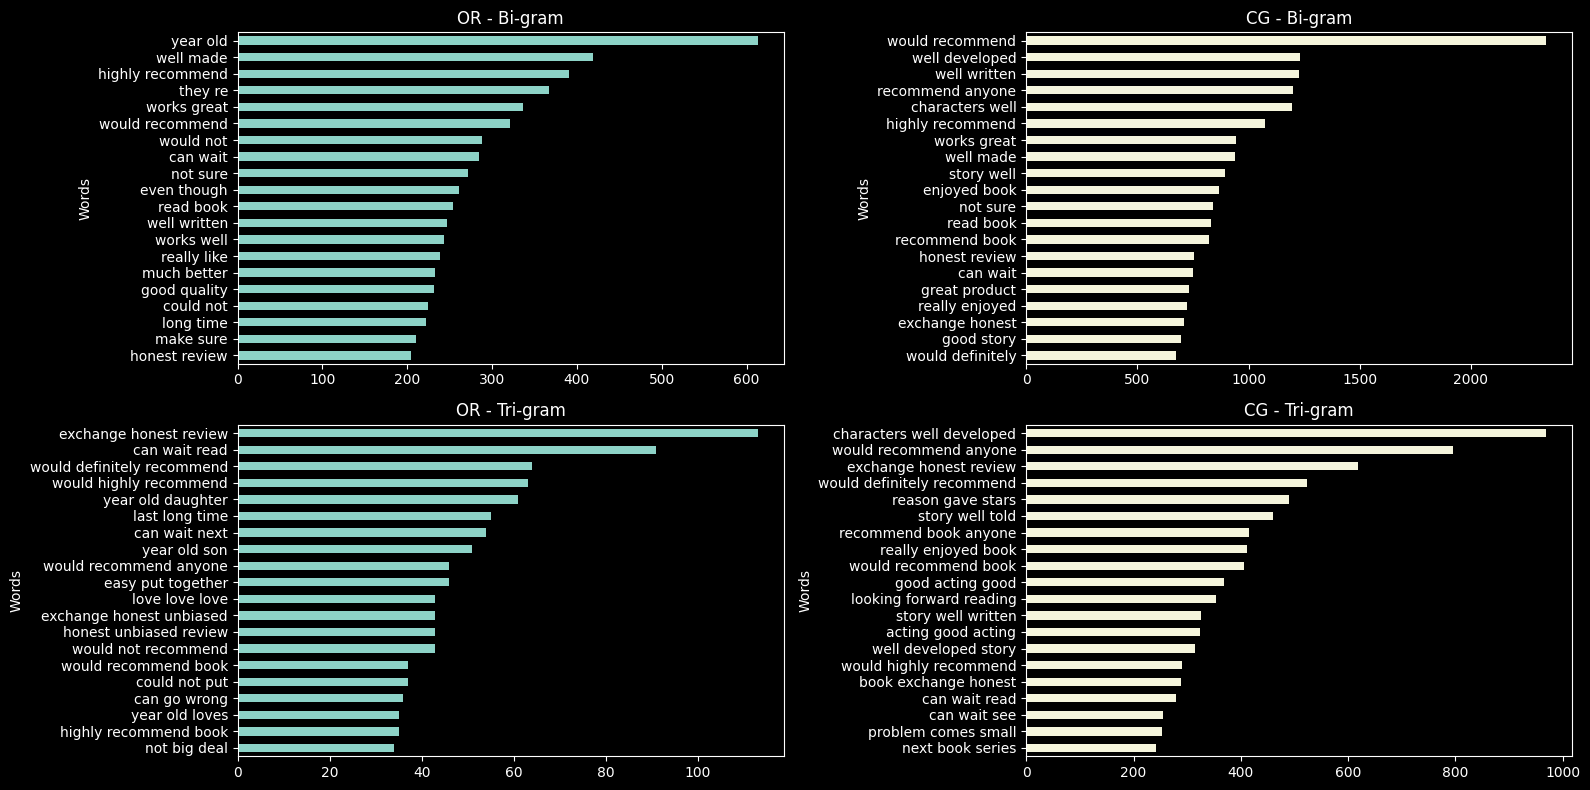

In [29]:
# Plot the top 20 bi-grams for each label
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
real_bi_gram_df.sort_values(by='Count').tail(20).plot.barh(x='Words', y='Count', ax=ax[0][0], legend=False)
fake_bi_gram_df.sort_values(by='Count').tail(20).plot.barh(x='Words', y='Count', ax=ax[0][1], legend=False, color='beige')
real_tri_gram_df.sort_values(by='Count').tail(20).plot.barh(x='Words', y='Count', ax=ax[1][0], legend=False)
fake_tri_gram_df.sort_values(by='Count').tail(20).plot.barh(x='Words', y='Count', ax=ax[1][1], legend=False, color='beige')

ax[0][0].set_title('OR - Bi-gram')
ax[0][1].set_title('CG - Bi-gram')
ax[1][0].set_title('OR - Tri-gram')
ax[1][1].set_title('CG - Tri-gram')

plt.tight_layout()
plt.show()

From the top 20 bi-grams and tri-grams, it is true that the fake reviews uses a lot more positive words the the real reviews.

#### Data Preprocessing

We will now process the dataset to be ready for our model training.

In [30]:
# Drop features that are not required
df.drop(['category', 'rating', 'text_'], axis=1, inplace=True)
df.sample(5)

,label,new_text_
384,OR,use pot everything second purchase
9720,OR,cable works fine hubby thought crap discovered...
31953,OR,author mentions not everyone going agree every...
24179,CG,samantha young woman come terms need man
19181,OR,well i've installed months ended purchasing di...


In [31]:
# Call function from acessory_func.py to tokenized and lemmatize the text
df['cleaned_text'] = af.preprocessing(df['new_text_'], lemma=True)

df.sample(5)

,label,new_text_,cleaned_text
13772,OR,i've looking movie last owned dvd received tod...,"[i've, look, movie, last, owned, dvd, receive,..."
20515,CG,week old boston terrier puppy started show sig...,"[week, old, boston, terrier, puppy, start, sho..."
10852,CG,going i've always wanted upgrade screen afford...,"[go, i've, always, want, upgrade, screen, affo..."
7866,CG,quite simply better set grips standard grip do...,"[quite, simply, well, set, grip, standard, gri..."
38735,CG,small simple love problem little large small l...,"[small, simple, love, problem, little, large, ..."


In [32]:
# Example of the text before and after lemmatization
print(f"Words before preprocess:\n{df['new_text_'].iloc[100]}\n")
print(f"Words after preprocess:\n{df['cleaned_text'].iloc[100]}")

Words before preprocess:
soft definitely better quality expecting

Words after preprocess:
['soft', 'definitely', 'well', 'quality', 'expect']


Encode the text into numbers using TF-IDF Vectorizer

In [33]:
# Split the cleaned text and label into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_text'], df['label'], test_size=0.3, random_state=42, 
                                                    shuffle=True, stratify=df['label'])

# Create TF-IDF vectorizer Object
tfidf = TfidfVectorizer(ngram_range=(1, 3), max_features=1000)

# Fit and transform the vectorizer on the train set
X_train_tfidf = tfidf.fit_transform(X_train.apply(lambda x: ' '.join(x))).toarray()

# Transform the vectorizer on the test set
X_test_tfidf = tfidf.transform(X_test.apply(lambda x: ' '.join(x))).toarray()

In [34]:
# Shape of the train and test sets after vectorization
print(f"Shape of train data: {X_train_tfidf.shape}")
print(f"Shape of test data: {X_test_tfidf.shape}")

Shape of train data: (28302, 1000)
Shape of test data: (12130, 1000)


Now the data is ready for model training!

#### Model Training using Pycaret
PyCaret is an open-source, low-code machine learning library in Python that automates machine learning workflows from training, visualization and hyper-parameter tuning in just a few lines of code. It will provide the result of  a few models for comparison, reducing the time to train models one by one.

To train the model using Pycaret, we need to prepare the dataset in to DataFrame

In [35]:
# Convert the train and test sets into DataFrame
df_X_train_tfidf = pd.DataFrame(X_train_tfidf, columns=tfidf.get_feature_names_out(), index=X_train.index)
df_X_test_tfidf = pd.DataFrame(X_test_tfidf, columns=tfidf.get_feature_names_out(), index=X_test.index)

df_X_train_tfidf

,able,absolutely,absolutely love,act,act good,act good act,action,actor,actually,adapter,...,write story,writer,wrong,year,year ago,year old,yes,yet,young,zipper
25463,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4972,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.412762,0.0,0.0,0.0,0.0,0.0,0.0
26476,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
16081,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
29441,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22878,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
19210,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.056608,0.0,0.0,0.0,0.0,0.0,0.0
32388,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.106517,0.0,...,0.0,0.0,0.0,0.072387,0.0,0.0,0.0,0.0,0.0,0.0
14882,0.141118,0.0,0.0,0.151108,0.197301,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
# Create the label column for the train and test DataFrames
df_X_train_tfidf['label'] = y_train
df_X_test_tfidf['label'] = y_test

The data is ready to be train in Pycaret. Take note that we do not need to encode our label as Pycaret will take care for us.

In [37]:
# import Pycaret classification module as our objective is to classify the reviews
from pycaret.classification import *

# Set up the pycaret environment
clf_model = setup(data=df_X_train_tfidf, target='label', session_id = 7491)

,Description,Value
0,Session id,7491
1,Target,label
2,Target type,Binary
3,Target mapping,"CG: 0, OR: 1"
4,Original data shape,"(28302, 1001)"
5,Transformed data shape,"(28302, 1001)"
6,Transformed train set shape,"(19811, 1001)"
7,Transformed test set shape,"(8491, 1001)"
8,Numeric features,1000
9,Preprocess,True


In [38]:
# Start training the models
compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.8528,0.0000,0.8528,0.8528,0.8527,0.7055,0.7056,0.3600
lda,Linear Discriminant Analysis,0.8518,0.9275,0.8518,0.8518,0.8518,0.7036,0.7036,2.8440
et,Extra Trees Classifier,0.8497,0.9212,0.8497,0.8497,0.8497,0.6994,0.6994,8.3250
lr,Logistic Regression,0.8494,0.9280,0.8494,0.8495,0.8494,0.6988,0.6989,1.7850
svm,SVM - Linear Kernel,0.8483,0.0000,0.8483,0.8491,0.8482,0.6966,0.6974,0.4630
catboost,CatBoost Classifier,0.8440,0.9293,0.8440,0.8444,0.8439,0.6879,0.6883,87.0070
lightgbm,Light Gradient Boosting Machine,0.8425,0.9290,0.8425,0.8430,0.8425,0.6850,0.6855,2.0700
rf,Random Forest Classifier,0.8316,0.9100,0.8316,0.8316,0.8316,0.6631,0.6632,4.9520
nb,Naive Bayes,0.7967,0.8333,0.7967,0.7993,0.7962,0.5934,0.5960,0.3030
gbc,Gradient Boosting Classifier,0.7810,0.8737,0.7810,0.7833,0.7805,0.5620,0.5643,11.5490


RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, positive=False, random_state=7491, solver='auto',
                tol=0.0001)

As we can see, Ridge Classifier provide the best result compared to other models. We will use it as our base model.

In [39]:
# Select the best model
base_model = create_model('ridge')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8496,0.0000,0.8496,0.8497,0.8496,0.6993,0.6993
1,0.8496,0.0000,0.8496,0.8496,0.8496,0.6991,0.6992
2,0.8597,0.0000,0.8597,0.8597,0.8597,0.7193,0.7194
3,0.8662,0.0000,0.8662,0.8665,0.8662,0.7325,0.7327
4,0.8380,0.0000,0.8380,0.8382,0.8379,0.6759,0.6761
5,0.8501,0.0000,0.8501,0.8501,0.8501,0.7002,0.7002
6,0.8491,0.0000,0.8491,0.8491,0.8491,0.6981,0.6981
7,0.8531,0.0000,0.8531,0.8532,0.8531,0.7062,0.7063
8,0.8642,0.0000,0.8642,0.8644,0.8642,0.7284,0.7286


#### Evaluation

We will look how the model performed on the hold-out dataset.

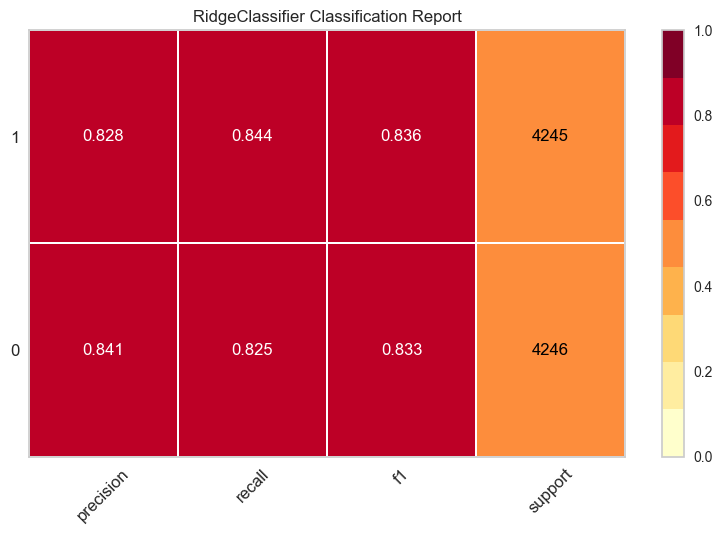

In [40]:
# Classification report for the base model
plot_model(base_model, plot='class_report')

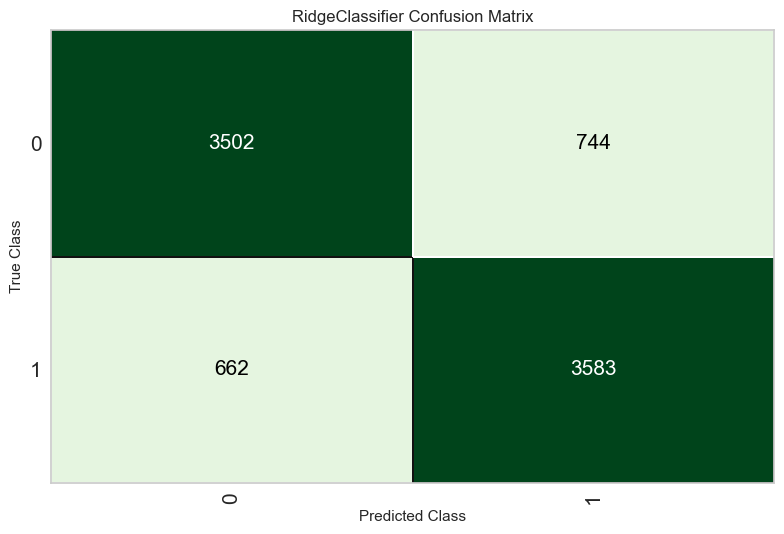

In [41]:
# Confusion matrix for the base model
plot_model(base_model, plot='confusion_matrix')

The model performed well with the hold-out dataset as we are getting over 82% across the metrics. We will performed hyper-parameter tuning to see if the model performance increased.

In [42]:
# Tune the base model
tune_ridge = tune_model(base_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8491,0.0000,0.8491,0.8492,0.8491,0.6983,0.6983
1,0.8501,0.0000,0.8501,0.8502,0.8501,0.7001,0.7002
2,0.8602,0.0000,0.8602,0.8602,0.8602,0.7203,0.7204
3,0.8677,0.0000,0.8677,0.8679,0.8677,0.7355,0.7356
4,0.8380,0.0000,0.8380,0.8381,0.8379,0.6759,0.6761
5,0.8501,0.0000,0.8501,0.8501,0.8501,0.7002,0.7002
6,0.8486,0.0000,0.8486,0.8486,0.8486,0.6971,0.6971
7,0.8521,0.0000,0.8521,0.8522,0.8521,0.7042,0.7043
8,0.8637,0.0000,0.8637,0.8638,0.8637,0.7274,0.7275


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


As shown, we are not getting any increase in the performance on the tuned model. We will thus stick to our base model. Now, we will use the test dataset and see how the base model performs.

In [43]:
# Classification report on test dataset
print(classification_report(y_test, predict_model(base_model, df_X_test_tfidf)['prediction_label']))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8459,0,0.8459,0.8459,0.8459,0.6918,0.6919


              precision    recall  f1-score   support

          CG       0.85      0.84      0.85      6065
          OR       0.84      0.85      0.85      6065

    accuracy                           0.85     12130
   macro avg       0.85      0.85      0.85     12130
weighted avg       0.85      0.85      0.85     12130



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Ridge Classifier,0.8459,0,0.8459,0.8459,0.8459,0.6918,0.6919


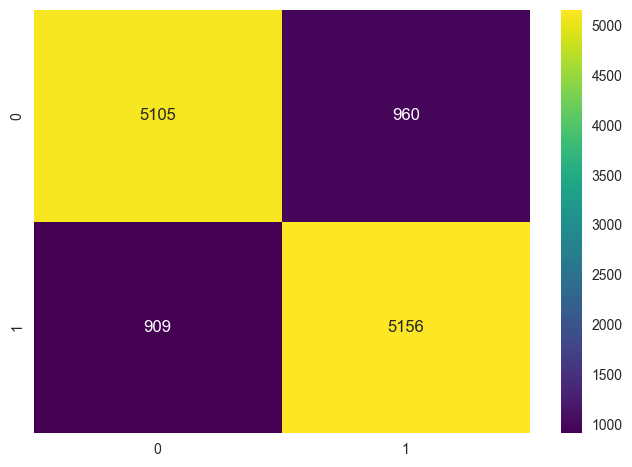

In [44]:
# Confusion matrix on test dataset
sns.heatmap(confusion_matrix(y_test, predict_model(base_model, df_X_test_tfidf)['prediction_label']),
            annot=True, fmt='d', cmap='viridis');

The model is doing well on the test dataset. We will save the model and TF-IDF tokenizer for future deployment if necessary.

\** Uncomment code in below cell to save the model and TF-IDF tokenizer

In [45]:
# import pickle
# with open('tfidf.pkl', 'wb') as f:
#     pickle.dump(tfidf, f)

# save_model(base_model, 'pycaret_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['able', 'absolutely',
                                              'absolutely love', 'act',
                                              'act good', 'act good act',
                                              'action', 'actor', 'actually',
                                              'adapter', 'add', 'addition',
                                              'adjust', 'adjustabl...
                                                               strategy='most_frequent',
                                                               verbose='deprecated'))),
                 ('clean_column_names',
                  Transfor